In [1]:
!pip install transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
t

In [2]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainer, Seq2SeqTrainingArguments
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import evaluate

In [3]:
dataset = load_dataset("MagedSaeed/xlsum_arabic_experimental")
train_data = dataset["train"]
test_data = dataset["test"]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/574 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/80.9M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/11.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/30000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4689 [00:00<?, ? examples/s]

Take subset of the dataset

In [4]:
train_data = dataset["train"].select(range(10000))
test_data = dataset["test"].select(range(1400))

In [5]:
columns_to_remove = ["gem_id", "url", "title", "references"]
train_data = train_data.remove_columns(columns_to_remove)
test_data = test_data.remove_columns(columns_to_remove)
print("columns in train_data:", train_data.column_names)
print("columns in test_data:", test_data.column_names)

columns in train_data: ['target', 'text']
columns in test_data: ['target', 'text']


Average text length: 423
Maximum text length: 4618
95% of texts below: 1164

Average summary length: 25
Maximum summary length: 222
95% of summaries below: 42


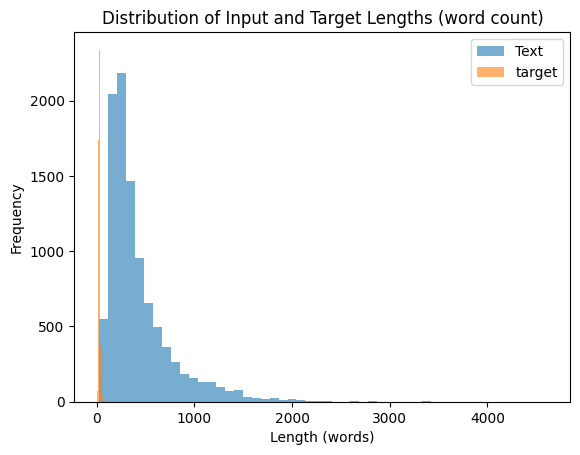

In [6]:
import matplotlib.pyplot as plt

data = train_data

input_lengths = [len(myData["text"].split()) for myData in data]
target_lengths = [len(myData["target"].split()) for myData in data]

print("Average text length:", sum(input_lengths) // len(input_lengths))
print("Maximum text length:", max(input_lengths))
print("95% of texts below:", sorted(input_lengths)[int(0.95 * len(input_lengths))])

print("\nAverage summary length:", sum(target_lengths) // len(target_lengths))
print("Maximum summary length:", max(target_lengths))
print("95% of summaries below:", sorted(target_lengths)[int(0.95 * len(target_lengths))])

plt.hist(input_lengths, bins=50, alpha=0.6, label='Text')
plt.hist(target_lengths, bins=50, alpha=0.6, label='target')
plt.title("Distribution of Input and Target Lengths (word count)")
plt.xlabel("Length (words)")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [7]:
mean_input_length = int(np.mean(input_lengths))
mean_target_length = int(np.mean(target_lengths))

print(f"Using max_length {mean_input_length} for Text Input and {mean_target_length} for Target.")


Using max_length 423 for Text Input and 25 for Target.


Load tokenizer and model

In [8]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_path = "aubmindlab/aragpt2-base"
print("Loading model and tokenizer...")

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(model_path)


Loading model and tokenizer...


config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.50M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.52M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/553M [00:00<?, ?B/s]

preprocessing function

In [9]:
def preprocess_function(examples):
    inputs = tokenizer(examples["text"], max_length=mean_input_length, truncation=True, padding="max_length") # Changed avg_input_length to mean_input_length
    targets = tokenizer(examples["target"], max_length=mean_target_length, truncation=True, padding="max_length") # Changed avg_target_length to mean_target_length
    inputs["labels"] = targets["input_ids"]
    return inputs

In [ ]:
tokenizer.pad_token = tokenizer.eos_token

print("Applying preprocessing to dataset...")
tokenized_train = train_data.map(preprocess_function, batched=True)
tokenized_test = test_data.map(preprocess_function, batched=True)


Applying preprocessing to dataset...


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

In [11]:
!pip install rouge_score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=112f76232f980c165d516d46a867888d9c668c94a3c646746cbbe31dd8d65fb4
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [12]:
rouge = evaluate.load("rouge")

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    preds = np.where(preds != -100, preds, tokenizer.pad_token_id)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    print("\nEvaluation ROUGE scores:", {k: round(v * 100, 4) for k, v in result.items()})
    return {k: round(v * 100, 4) for k, v in result.items()}

In [ ]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False 
)


In [14]:



from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./finetuned_aragpt2_xlsum",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=3,
    logging_dir="./logs",
    logging_steps=50,
    push_to_hub=False,
    report_to="none"
)


In [15]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


<ipython-input-15-708e10646b6e>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [16]:
trainer.train()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
50,7.624300
100,6.079100
150,5.365800


Step,Training Loss
50,7.624300
100,6.079100
150,5.365800
200,5.089000
250,4.904800
300,4.786000
350,4.669400
400,4.632300
450,4.580800
500,4.534400


TrainOutput(global_step=3750, training_loss=4.223680651855469, metrics={'train_runtime': 4071.9162, 'train_samples_per_second': 7.368, 'train_steps_per_second': 0.921, 'total_flos': 6476163840000000.0, 'train_loss': 4.223680651855469, 'epoch': 3.0})

In [21]:
!pip install evaluate


In [23]:
import evaluate
rouge = evaluate.load("rouge")


In [ ]:
def evaluate_rouge(model, tokenizer, dataset, num_samples=100):
    import evaluate
    rouge = evaluate.load("rouge")

    model.eval()
    preds = []
    refs = []

    for i in range(min(num_samples, len(dataset))):
        input_text = dataset[i]["text"]
        reference = dataset[i]["target"]

        input_ids = tokenizer.encode(
            input_text,
            return_tensors="pt",
            truncation=True,
            max_length=512
        ).to(model.device)

        attention_mask = (input_ids != tokenizer.pad_token_id).long()

        output_ids = model.generate(
            input_ids,
            attention_mask=attention_mask,
            max_new_tokens=128,
            num_beams=4,
            do_sample=False,
            pad_token_id=tokenizer.pad_token_id
        )

        predicted = tokenizer.decode(output_ids[0], skip_special_tokens=True)

        preds.append(predicted)
        refs.append(reference)

    # Compute ROUGE
    rouge_scores = rouge.compute(predictions=preds, references=refs, use_stemmer=True)

    result = {
    "ROUGE-1": round(rouge_scores["rouge1"], 4),
    "ROUGE-2": round(rouge_scores["rouge2"], 4),
    "ROUGE-L": round(rouge_scores["rougeL"], 4)
    }

    return result


In [33]:
results = evaluate_rouge(model, tokenizer, test_data)
print("📊 ROUGE Scores:")
for key, score in results.items():
    print(f"{key}: {score}")


📊 ROUGE Scores:
ROUGE-1: 0.0208
ROUGE-2: 0.0
ROUGE-L: 0.0209


In [34]:
def summarize_example(model, tokenizer, text, max_new_tokens=128):
    model.eval()

    input_ids = tokenizer.encode(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=512
    ).to(model.device)

    attention_mask = (input_ids != tokenizer.pad_token_id).long()

    output_ids = model.generate(
        input_ids,
        attention_mask=attention_mask,
        max_new_tokens=max_new_tokens,
        num_beams=4,
        do_sample=False,
        pad_token_id=tokenizer.pad_token_id
    )

    summary = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return summary


In [35]:
text = """
قالت وزارة التعليم إن العام الدراسي المقبل سيتضمن 3 فصول دراسية بدلًا من فصلين،
ويأتي القرار في إطار تطوير المناهج وتحسين جودة التعليم بما يتماشى مع رؤية المملكة 2030.
"""

generated_summary = summarize_example(model, tokenizer, text)
print("📄 النص الأصلي:\n", text)
print("\n📝 التلخيص المتوقع:\n", generated_summary)


📄 النص الأصلي:
 
قالت وزارة التعليم إن العام الدراسي المقبل سيتضمن 3 فصول دراسية بدلًا من فصلين، 
ويأتي القرار في إطار تطوير المناهج وتحسين جودة التعليم بما يتماشى مع رؤية المملكة 2030.


📝 التلخيص المتوقع:
 
قالت وزارة التعليم إن العام الدراسي المقبل سيتضمن 3 فصول دراسية بدلًا من فصلين، 
ويأتي القرار في إطار تطوير المناهج وتحسين جودة التعليم بما يتماشى مع رؤية المملكة 2030.

وقالت وزارة التعليم إن الفصل الدراسي الجديد سيتضمن 3 فصول دراسية بدلًا من فصلين بدلا من فصلين.

وقالت وزارة التعليم إن الفصل الدراسي الجديد سيتضمن 3 فصول دراسية بدلًا من فصلين بدلا من فصلين، 

وقالت الوزارة إن الفصل الدراسي الجديد سيتضمن 3 فصول دراسية بدلًا من فصلين بدلًا من فصلين بدلا من فصلين بدلا من فصلين بدلا من فصلين بدلا من فصلين بدلا من فصلين بدلا من فصلين بدلا من فصلين بدلا من فصلين بدلا من فصلين بدلا من فصلين بدلا من فصلين بدلا من فصلين


In [36]:
model.save_pretrained("finetuned_model_arabic")
tokenizer.save_pretrained("finetuned_model_arabic")


('finetuned_model_arabic/tokenizer_config.json',
 'finetuned_model_arabic/special_tokens_map.json',
 'finetuned_model_arabic/vocab.json',
 'finetuned_model_arabic/merges.txt',
 'finetuned_model_arabic/added_tokens.json',
 'finetuned_model_arabic/tokenizer.json')

In [37]:
model.save_pretrained("finetuned_model_arabic")


## تحسين المودل اكتر 
## منزيد الايبوكس ل 5

In [ ]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling
import evaluate

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)


In [ ]:
rouge = evaluate.load("rouge")

def compute_metrics(eval_preds):
    preds, labels = eval_preds

    preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    preds = [p.strip() for p in preds]
    labels = [l.strip() for l in labels]

    result = rouge.compute(predictions=preds, references=labels, use_stemmer=True)

    print("\n📊 ROUGE Results during training:")
    print(f"ROUGE-1: {round(result['rouge1'], 4)}")
    print(f"ROUGE-2: {round(result['rouge2'], 4)}")
    print(f"ROUGE-L: {round(result['rougeL'], 4)}")

    return {
        "rouge1": round(result["rouge1"], 4),
        "rouge2": round(result["rouge2"], 4),
        "rougeL": round(result["rougeL"], 4)
    }

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./finetuned_aragpt2_xlsum",
    learning_rate=3e-5,                    
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,                      
    num_train_epochs=5,                    
    save_total_limit=3,                     
    warmup_steps=500,                        
    gradient_accumulation_steps=2,            
    fp16=True,                               
    logging_dir="./logs",
    logging_steps=100,                       
    report_to="none",
)


In [44]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

<ipython-input-44-607832571afd>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [47]:
trainer.train()

Step,Training Loss
100,3.878200
200,3.828100
300,3.815200
400,3.789400
500,3.806500
600,3.769400
700,3.726300
800,3.713800
900,3.736400
1000,3.702000


TrainOutput(global_step=3125, training_loss=3.6664765698242188, metrics={'train_runtime': 2678.1785, 'train_samples_per_second': 18.669, 'train_steps_per_second': 1.167, 'total_flos': 1.07936064e+16, 'train_loss': 3.6664765698242188, 'epoch': 5.0})

In [ ]:
def evaluate_rouge(model, tokenizer, dataset, num_samples=100):
    import evaluate
    rouge = evaluate.load("rouge")

    model.eval()
    preds = []
    refs = []

    for i in range(min(num_samples, len(dataset))):
        input_text = dataset[i]["text"]
        reference = dataset[i]["target"]

        input_ids = tokenizer.encode(
            input_text,
            return_tensors="pt",
            truncation=True,
            max_length=512
        ).to(model.device)

        attention_mask = (input_ids != tokenizer.pad_token_id).long()

        output_ids = model.generate(
            input_ids,
            attention_mask=attention_mask,
            max_new_tokens=128,
            num_beams=4,
            do_sample=False,
            pad_token_id=tokenizer.pad_token_id
        )

        predicted = tokenizer.decode(output_ids[0], skip_special_tokens=True)

        preds.append(predicted)
        refs.append(reference)

    rouge_scores = rouge.compute(predictions=preds, references=refs, use_stemmer=True)

    result = {
    "ROUGE-1": round(rouge_scores["rouge1"], 4),
    "ROUGE-2": round(rouge_scores["rouge2"], 4),
    "ROUGE-L": round(rouge_scores["rougeL"], 4)
    }

    return result


In [49]:
results = evaluate_rouge(model, tokenizer, test_data)
print("📊 ROUGE Scores:")
for key, score in results.items():
    print(f"{key}: {score}")


📊 ROUGE Scores:
ROUGE-1: 0.0177
ROUGE-2: 0.0
ROUGE-L: 0.0178


In [50]:
def summarize_example(model, tokenizer, text, max_new_tokens=128):
    model.eval()

    input_ids = tokenizer.encode(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=512
    ).to(model.device)

    attention_mask = (input_ids != tokenizer.pad_token_id).long()

    output_ids = model.generate(
        input_ids,
        attention_mask=attention_mask,
        max_new_tokens=max_new_tokens,
        num_beams=4,
        do_sample=False,
        pad_token_id=tokenizer.pad_token_id
    )

    summary = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return summary


In [51]:
text = """
قالت وزارة التعليم إن العام الدراسي المقبل سيتضمن 3 فصول دراسية بدلًا من فصلين،
ويأتي القرار في إطار تطوير المناهج وتحسين جودة التعليم بما يتماشى مع رؤية المملكة 2030.
"""

generated_summary = summarize_example(model, tokenizer, text)
print("📄 النص الأصلي:\n", text)
print("\n📝 التلخيص المتوقع:\n", generated_summary)


📄 النص الأصلي:
 
قالت وزارة التعليم إن العام الدراسي المقبل سيتضمن 3 فصول دراسية بدلًا من فصلين، 
ويأتي القرار في إطار تطوير المناهج وتحسين جودة التعليم بما يتماشى مع رؤية المملكة 2030.


📝 التلخيص المتوقع:
 
قالت وزارة التعليم إن العام الدراسي المقبل سيتضمن 3 فصول دراسية بدلًا من فصلين، 
ويأتي القرار في إطار تطوير المناهج وتحسين جودة التعليم بما يتماشى مع رؤية المملكة 2030.

وقالت وزارة التعليم إن العام الدراسي المقبل سيتضمن 3 فصول دراسية بدلًا من فصلين بدلًا من فصلين بدلًا من فصلين بدلًاًاًاًاًاًاًاًاًاًاًاًاًاًاًاًاًاًاًاًاًاًاًاًاًاًاًاًاًاًاًا
